## Package Governance - Custom Pip Packages

For enterprise environments, it is very important to control the access and usage of modules and libraries. There are multiple ways of governing packages and modules in Cloud Pak for Data. In this example, we will show how to upload a `pip` package into the CPD cluster, configure a custom environment, and users will be able to access this package without having to manually installing it in their notebook runtime environment.

Prerequites:
  - some CLI tools are needed for this tutorial (`oc, git, zip, pip`) as well as a Linux/Mac command line environment
  - to upload to the cluster shared storage, the user has to be a OpenShift admin (or have access to the CPD installation namespace) and has access to the CPD shared storage
  - to create custom environments, the user has to have admin or editor role in CPD platform

### 1) Prepare Package Locally

In this example, we will fetch a package from source from Github, and upload to our CPD cluster. However, your package file can be an existing package from your repository or your own source code.


Download and zip into a file prepared to be uploaded

```
git clone https://github.com/Trusted-AI/AIF360.git
zip aif-latest.zip ./AIF360 -r
export PIP_PCKAGE_NAME=aif-latest.zip
```

Optionally, test the installation on your local machine by running pip install

```
# pip install aif-latest.zip

```

### 2) Upload to CPD Cluster Shared Storage

Switch to project where CPD control plane is installed and find NGINX Pod

```
oc project zen
ibm_nginx_pod=`oc get pods -l component=ibm-nginx -o jsonpath='{.items[0].metadata.name}'`
```

Copy your package to the pod mounted with shared storage

```
oc cp ${PIP_PCKAGE_NAME} ${ibm_nginx_pod}:/user-home/_global_/config/conda/ 
oc exec ${ibm_nginx_pod} -- chmod a+r "/user-home/_global_/config/conda/aif-latest.zip" 
```



Verify the package is now in the shared global storage

```
oc exec ${ibm_nginx_pod} -- ls -la "/user-home/_global_/config/conda/"
```



Results

```
total 8732
drwxr-x---.  2 1000620000 root      28 Aug 24 18:37 .
drwxr-xr-x. 13 1000620000 root     205 Aug 24 12:35 ..
-rw-r--r--.  1 1000620000 root 8939508 Aug 24 18:37 aif-latest.zip
```

### 3) Create Environment Customization

Create an environment customization similar to one below which would point to the custom package we are including in our environment


Create new environment by navigating to "Environments" in your project, then click "New environment definition" under "Environment definitions" section

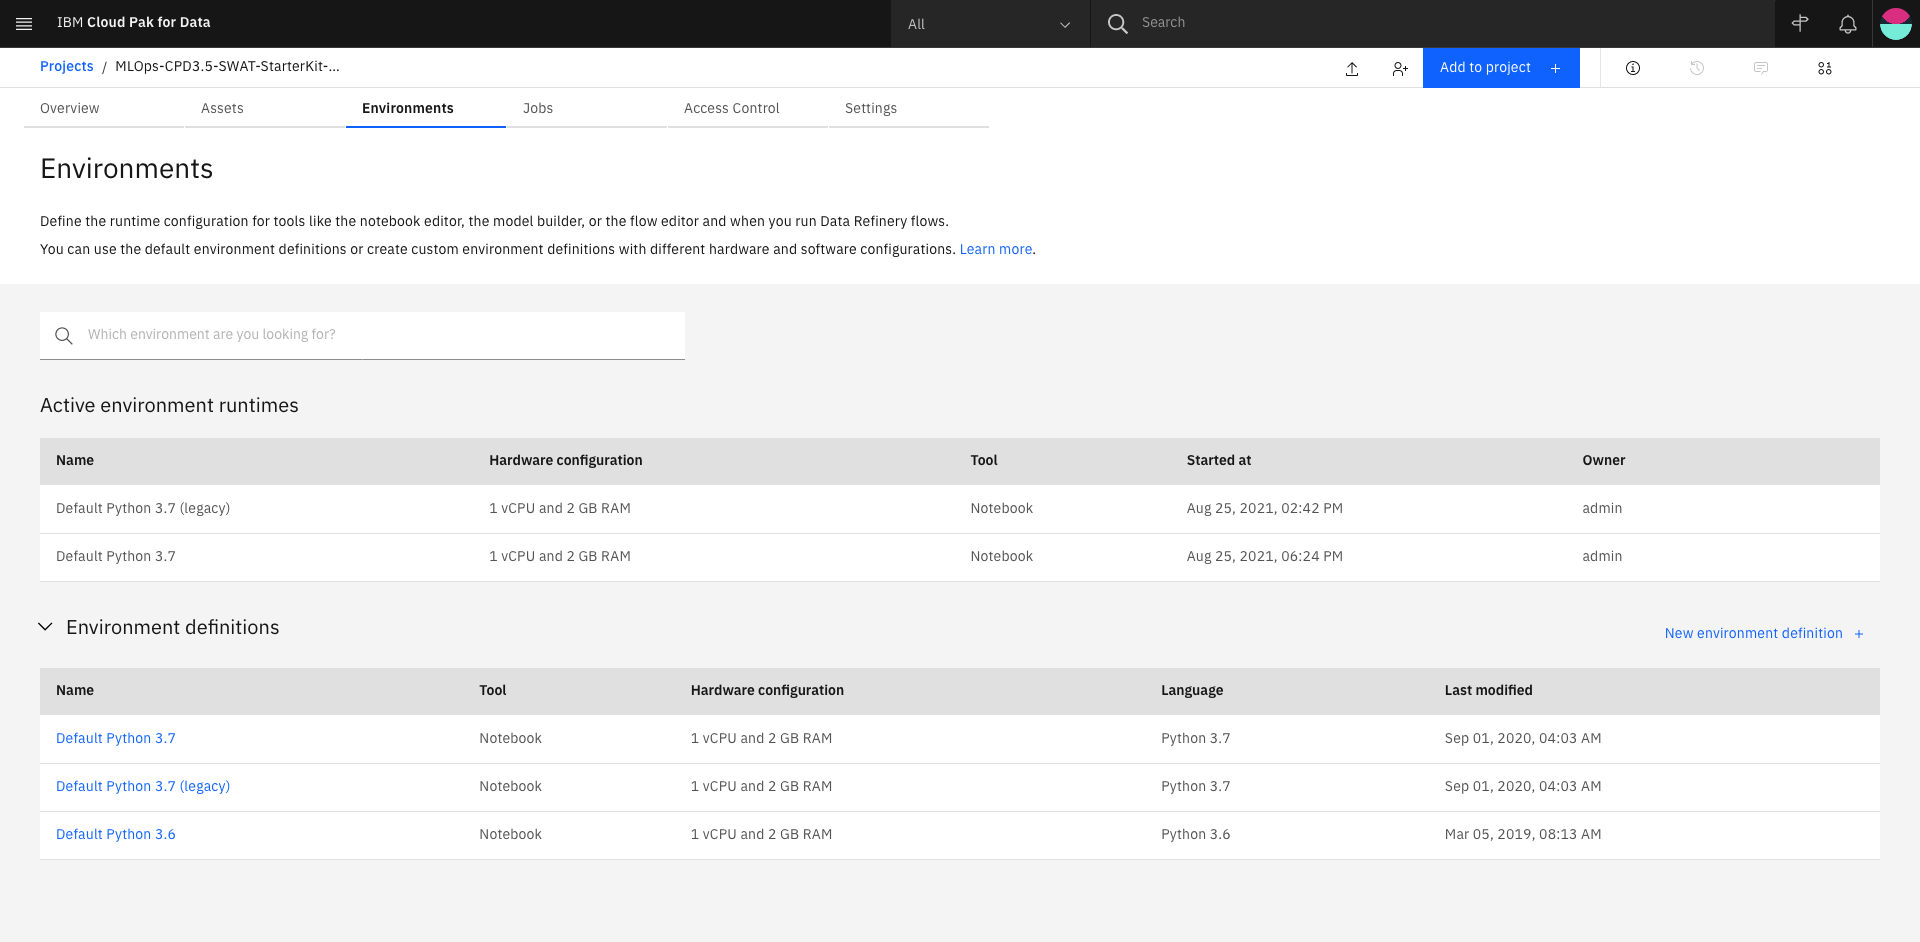



Then give your custom environment a name, and click "Create"
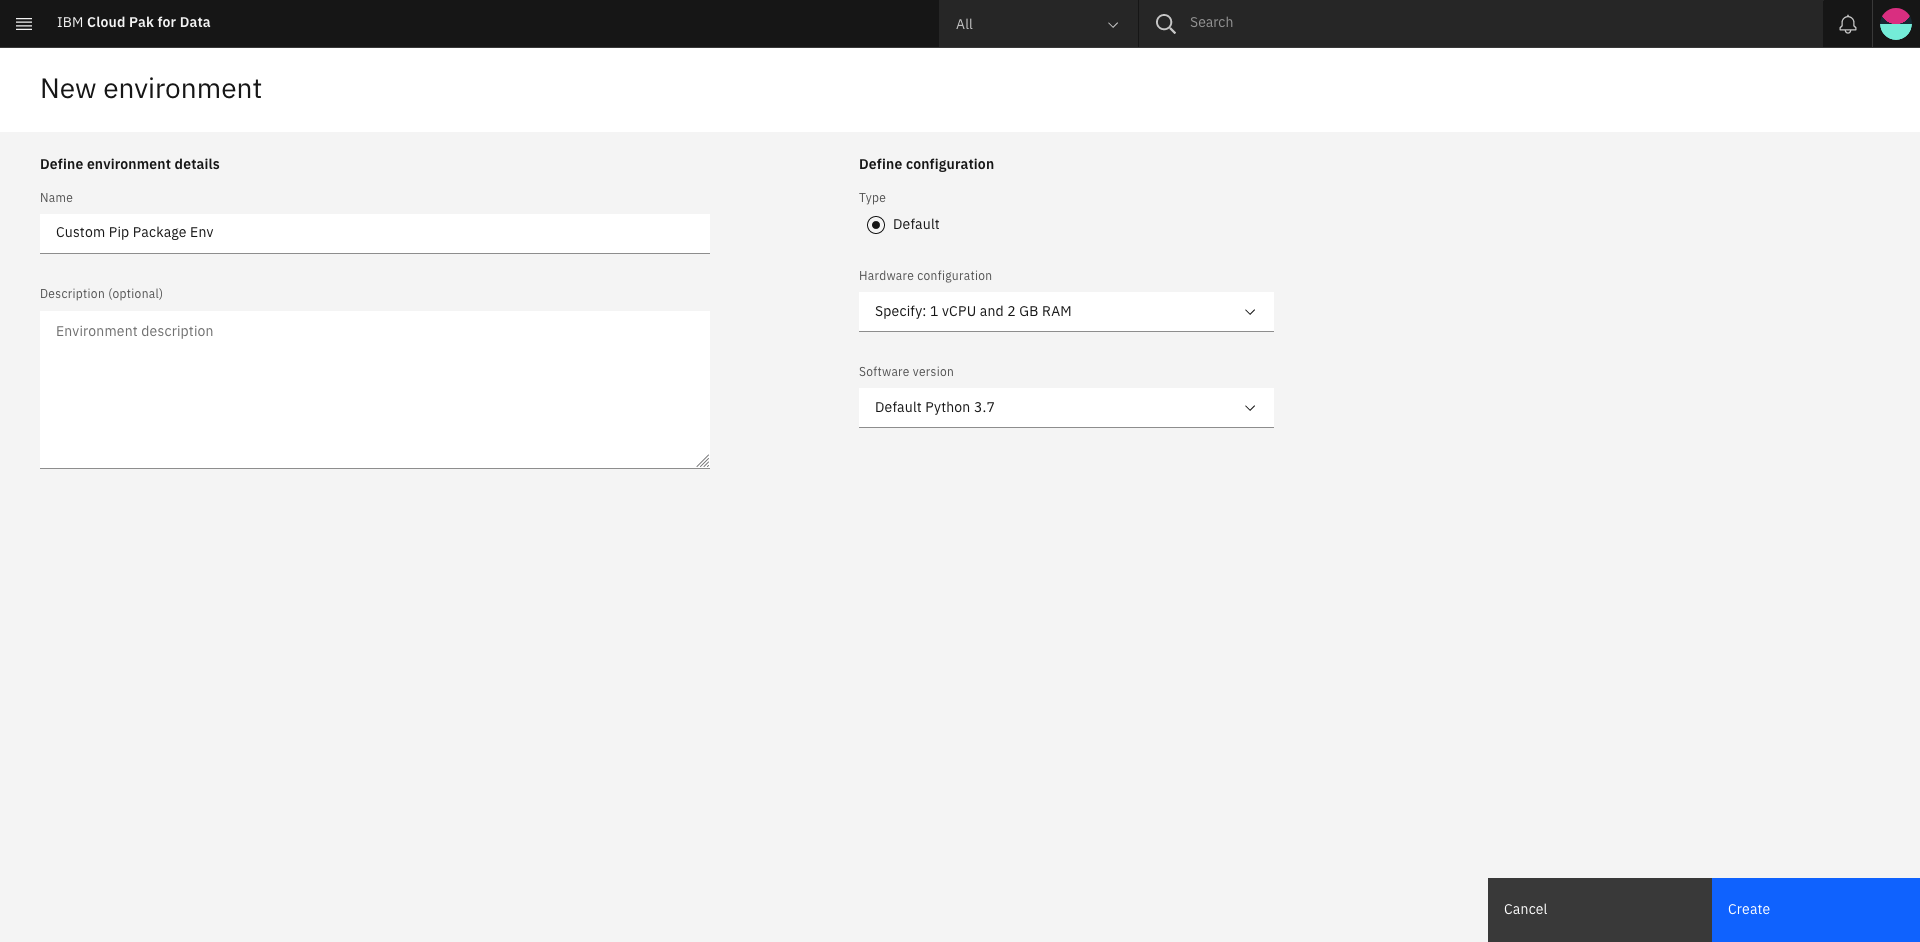

After we created the new environment, we want to apply the customization. Click "Create" now under the "Customization" section

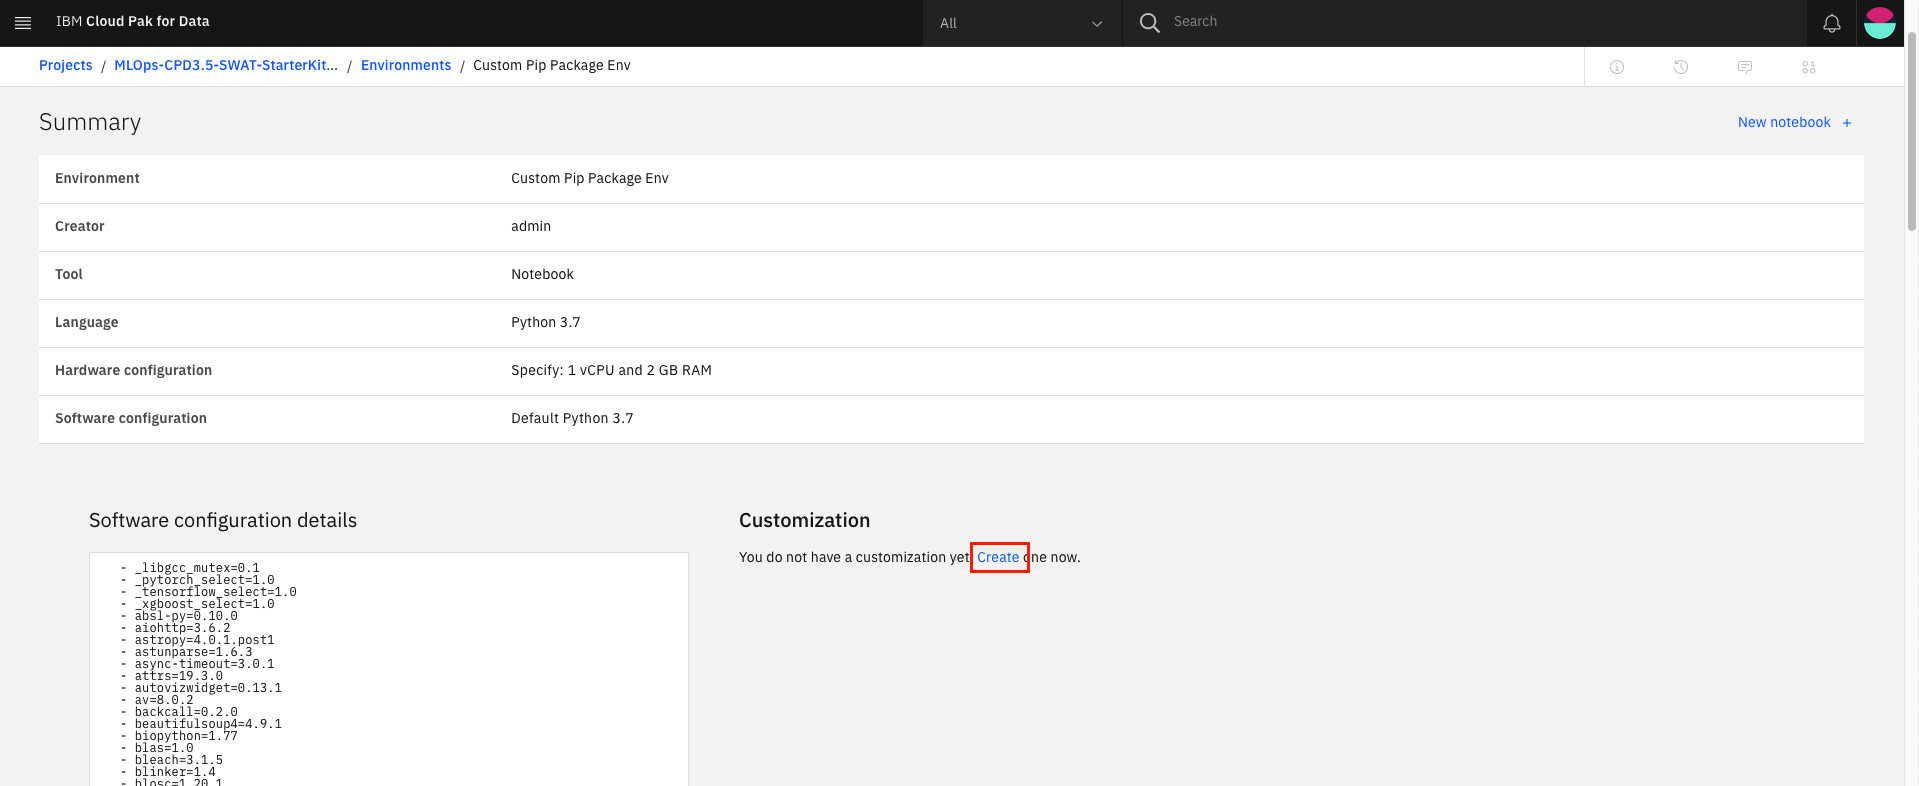

Copy the following snippet as an example which will include our local pip package as our custom environment definition, which we can then use and import into our notebook without having to manaully install the `aif` package. Then we press "Apply".



```
# Add conda channels below defaults, indented by two spaces and a hyphen.
channels:
  - nodefaults

# To add packages through conda or pip, remove the # on the following line.
dependencies:

# Add pip packages here, indented by four spaces and a hyphen.
# Remove the comments on the following lines and replace sample package name with your package name.
  - pip:
    - file:///user-home/_global_/config/conda/aif-latest.zip
```


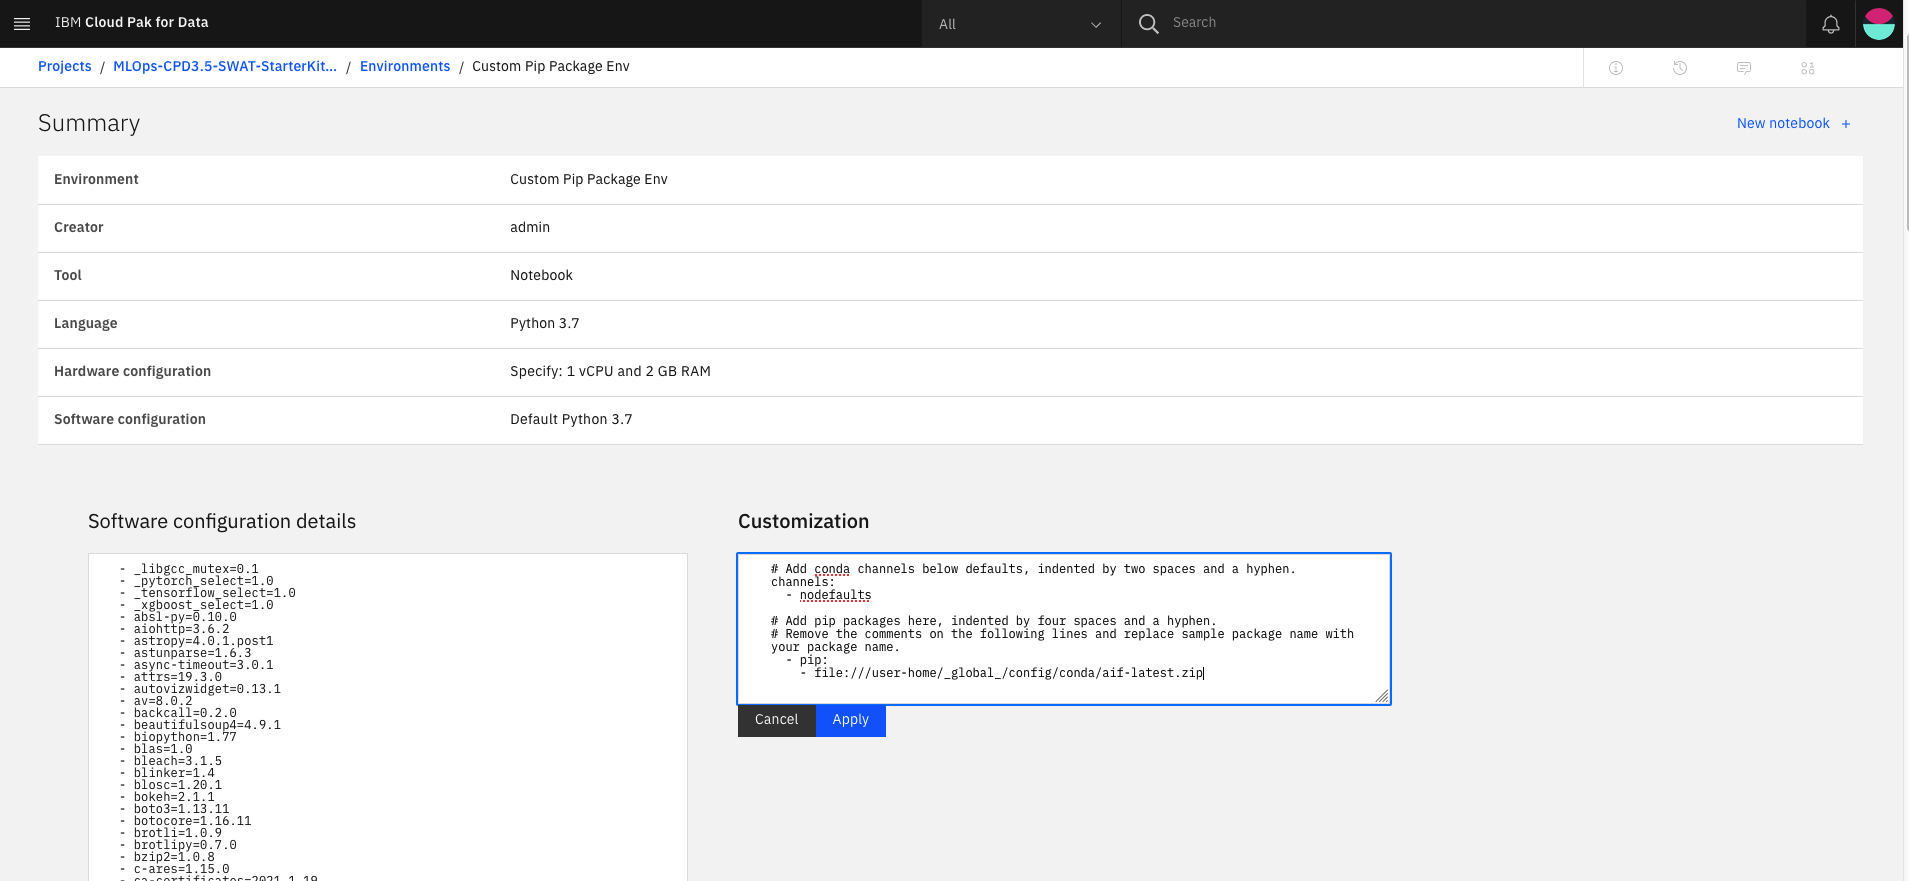

### 4) Using the Custom Environment

Now we are able to create a new notebook with this custom environment

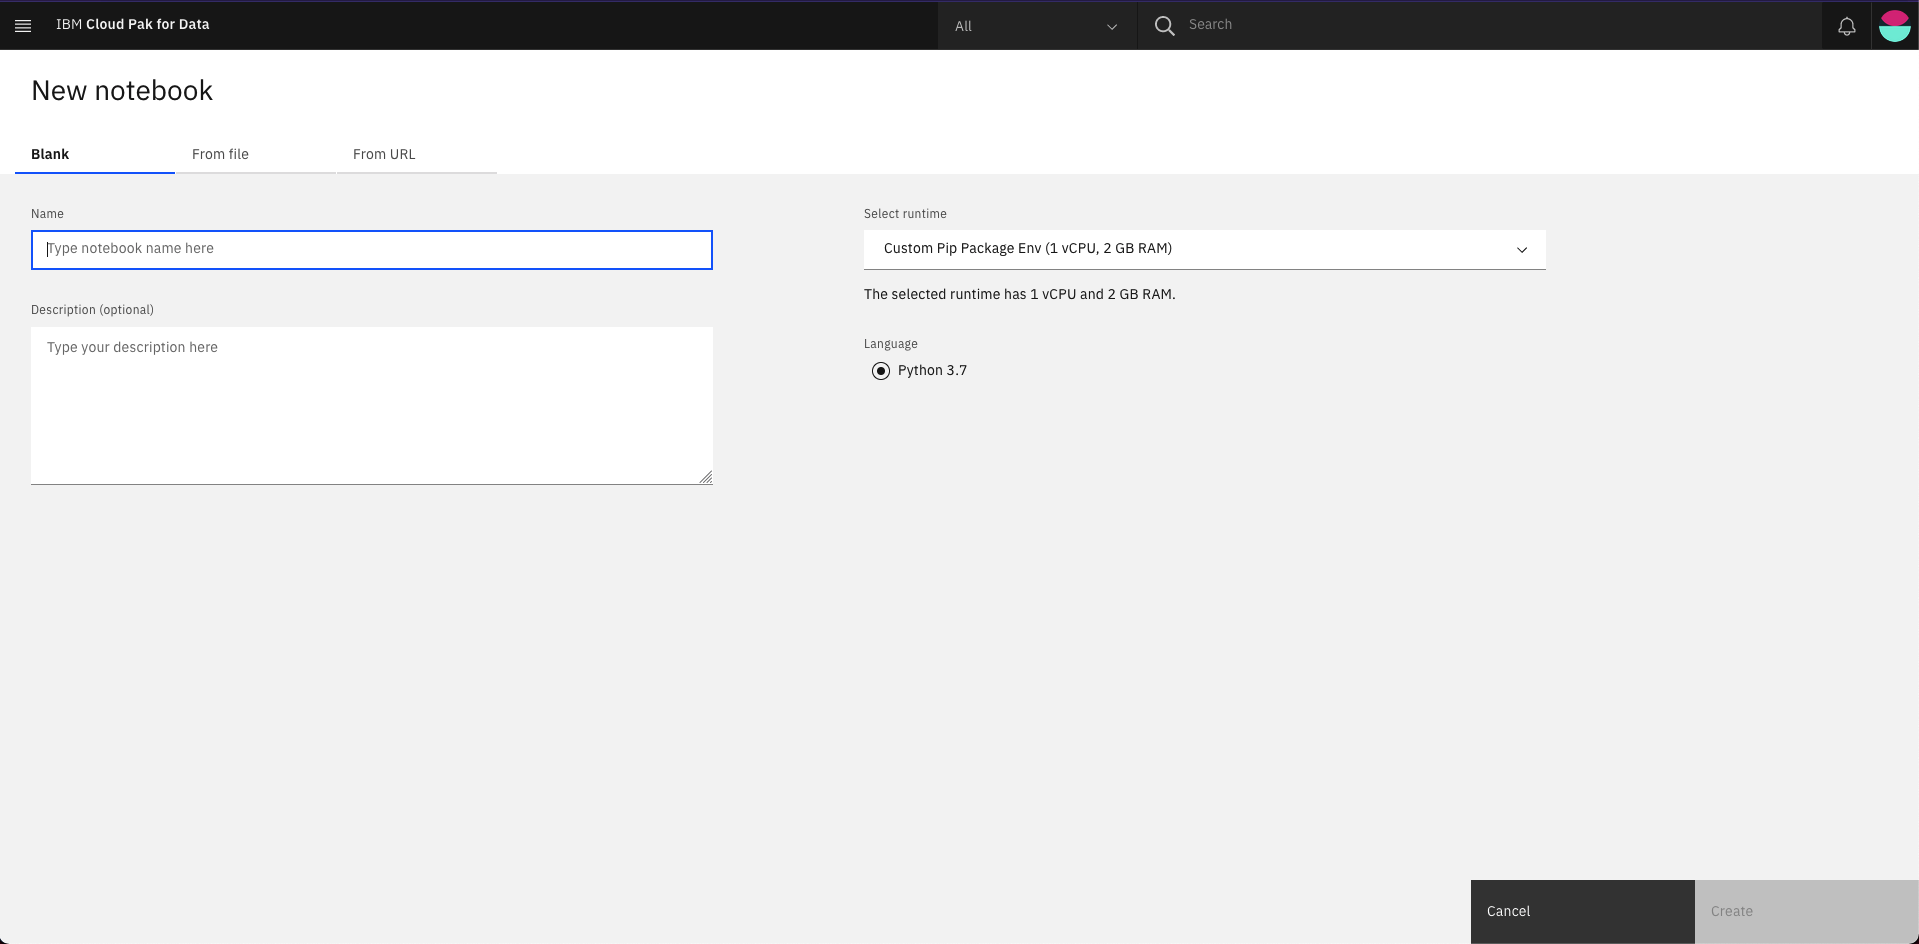

The notebook is now able to call the import statement of this package without having to manually installing it before hand.

`import aif360`

### References

- https://www.ibm.com/docs/en/cloud-paks/cp-data/3.5.0?topic=pip-customizing